# Import the dependencies

In [1]:
import re
import random
import numpy as np
import pandas as pd

from tqdm import tqdm

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, LSTM
from keras.callbacks import ModelCheckpoint

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

from matplotlib import pyplot as plt
from matplotlib import rcParams

import sys
import time

sys.path.append("../")
from calculus_path_mod.terms.pseudonym import *
from calculus_path_mod.reduction_strategy import *
from calculus_path_mod.terms.arithm_complex_ops import *

In [2]:
epochs = 5
num_lstm_neurons = 256
num_pre_out_neurons = 256
onehot_dims = 5

# Load & Prepare the data

In [3]:
enc_dict = {"(": [1.0, .0, .0, .0, .0],
            ")": [.0, 1.0, .0, .0, .0],
            "I": [.0, .0, 1.0, .0, .0],
            "K": [.0, .0, .0, 1.0, .0],
            "S": [.0, .0, .0, .0, 1.0]}


def tokenize_data(comb_str_term: str):
    return list(comb_str_term.replace(" ", ""))


def tokenize_and_vectorize(x_data):
    vectorized_data_ = []
    for sample_ in x_data:
        tokens_ = tokenize_data(sample_)
        sample_vecs_ = []
        for token_ in tokens_:
            try:
                sample_vecs_.append(enc_dict[token_])
            except KeyError:
                pass
        vectorized_data_.append(sample_vecs_)
    return vectorized_data_

In [4]:
all_data = pd.read_csv("../lstm_lo_steps_prediction/data/steps_combi_term_str.csv", delimiter=',')

# leave only unique terms
print(f"Count all terms: {len(all_data)}\n")
all_data = all_data.drop_duplicates(subset="comb_terms").reset_index(drop=True)
print(f"Count original terms: {len(all_data)}\n")

# shuffle the dataset
all_data = shuffle(all_data, random_state=33).reset_index(drop=True)

# filter out steps_lo that are more than 30
all_data = all_data[[steps_lo < 31 for steps_lo in all_data['steps_num_lo']]]

print(f"max steps count: {max(all_data['steps_num_lo'])}")
print(f"min steps count: {min(all_data['steps_num_lo'])}")

# make test/train split
x_train, x_test, y_train_, y_test_ = train_test_split(all_data["comb_terms"].tolist(),
                                                      all_data["steps_num_lo"].tolist(),
                                                      test_size=0.2, random_state=42)

# print(f"Count training samples: {len(y_train_)}")
print(f"Count testing samples: {len(y_test_)}")

Count all terms: 4163

Count original terms: 4163

max steps count: 30
min steps count: 0
Count testing samples: 721


In [5]:
print("Load additional dataset")
all_data = pd.read_csv("../lstm_lo_steps_prediction/data/steps_combi_term_str_v1_0-2.csv", delimiter=',')
all_data = pd.concat([all_data, pd.read_csv("../lstm_lo_steps_prediction/data/steps_combi_term_str_v1_3-5.csv", delimiter=',')])
all_data = pd.concat([all_data, pd.read_csv("../lstm_lo_steps_prediction/data/steps_combi_term_str_v1_6-8.csv", delimiter=',')])
all_data = pd.concat([all_data, pd.read_csv("../lstm_lo_steps_prediction/data/steps_combi_term_str_v1_9-11.csv", delimiter=',')])
all_data = pd.concat([all_data, pd.read_csv("../lstm_lo_steps_prediction/data/steps_combi_term_str_v1_12-14.csv", delimiter=',')])
all_data = pd.concat([all_data, pd.read_csv("../lstm_lo_steps_prediction/data/steps_combi_term_str_v1_15-17.csv", delimiter=',')])
all_data = pd.concat([all_data, pd.read_csv("../lstm_lo_steps_prediction/data/steps_combi_term_str_v1_18-19.csv", delimiter=',')])


# leave only unique terms
print(f"Count all terms: {len(all_data)}\n")
all_data = all_data.drop_duplicates(subset="comb_terms").reset_index(drop=True)
print(f"Count original terms: {len(all_data)}\n")

# shuffle the dataset
all_data = shuffle(all_data, random_state=33).reset_index(drop=True)

# filter out steps_lo that are more than 30
all_data = all_data[[steps_lo < 31 for steps_lo in all_data['steps_num_lo']]]

print(f"max steps count: {max(all_data['steps_num_lo'])}")
print(f"min steps count: {min(all_data['steps_num_lo'])}")

train_df_0 = pd.DataFrame({"steps_num_lo": y_train_, "comb_terms": x_train})
all_data = pd.concat([all_data, train_df_0])

x_train, y_train_ = all_data["comb_terms"].tolist(), all_data["steps_num_lo"].tolist()

print(f"Count training samples: {len(y_train_)}")

Load additional dataset
Count all terms: 44410

Count original terms: 43745

max steps count: 30
min steps count: 0
Count training samples: 40474


In [6]:
# one-hot encode y-data
encoder = LabelBinarizer()
encoder.fit(range(0, 31))
y_train = encoder.transform(y_train_)
y_test = encoder.transform(y_test_)

y_train_scaled = np.array(y_train_) / 30.0
y_test_scaled = np.array(y_test_) / 30.0

x_train = tokenize_and_vectorize(x_train)
x_test = tokenize_and_vectorize(x_test)

In [7]:
xy_train_data = list(zip(x_train, list(zip(y_train, y_train_scaled))))
xy_test_data = list(zip(x_test, list(zip(y_test, y_test_scaled))))

In [8]:
print(f"len(test_data) = {len(xy_test_data)}")
print(f"len(train_data) = {len(xy_train_data)}")

len(test_data) = 721
len(train_data) = 40474


In [9]:
def train_generator():
    while True:
        random.shuffle(xy_train_data)
        for xtd, ytd in xy_train_data:
            yield np.array([xtd]), (np.array([ytd[0]]), np.array([ytd[1]]))


def val_generator():
    while True:
        for xtd, ytd in xy_test_data:
            yield np.array([xtd]), (np.array([ytd[0]]), np.array([ytd[1]]))

# Define the model

In [10]:
from keras.layers import Input
from keras.models import Model

input_layer = Input(shape=(None, onehot_dims))
lstm_layer = LSTM(units=num_lstm_neurons)(input_layer)

pre_out_layer = Dense(units=num_pre_out_neurons, activation="relu")(lstm_layer)

output_cl_layer = Dense(units=31, activation="softmax", name="cl_out")(pre_out_layer)
output_reg_layer = Dense(units=1, name="reg_out")(pre_out_layer)

model = Model(inputs=input_layer, outputs=[output_cl_layer, output_reg_layer])

In [11]:
model.compile(loss={'cl_out': 'categorical_crossentropy',
                    'reg_out': 'mean_squared_error'},
              loss_weights={'cl_out': 0.9,
                            'reg_out': 0.1},
              optimizer='adam',
              metrics={'cl_out': ['accuracy'], 'reg_out': ['mean_absolute_error']})
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 5)]    0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 256)          268288      ['input_1[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 256)          65792       ['lstm[0][0]']                   
                                                                                                  
 cl_out (Dense)                 (None, 31)           7967        ['dense[0][0]']                  
                                                                                              

In [14]:
model_structure = model.to_json()
with open("./fine_models/v6.1_lstm_steps_pred_31_bins.json", 'w') as json_file:
    json_file.write(model_structure)

In [15]:
# Define the ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath='./fine_models/v6.1_lstm_steps_pred_31_bins.h5',  # Specify the path to save the best model
    monitor='cl_out_accuracy',  # Metric to monitor (e.g., validation loss)
    save_best_only=True,  # Save only the best model
    mode='max',  # 'min' or 'max' depending on the monitored metric
    verbose=0  # Print a message when saving the model
)

In [ ]:
history = model.fit(train_generator(), steps_per_epoch=40474, validation_data=val_generator(), validation_steps=721, epochs=epochs, verbose=1, callbacks=[checkpoint_callback])

Epoch 1/5
40474/40474 [==============================] - 1923s 47ms/step - loss: 2.7190 - cl_out_loss: 3.0154 - reg_out_loss: 0.0518 - cl_out_accuracy: 0.1046 - reg_out_mean_absolute_error: 0.1760 - val_loss: 2.6203 - val_cl_out_loss: 2.9070 - val_reg_out_loss: 0.0397 - val_cl_out_accuracy: 0.1595 - val_reg_out_mean_absolute_error: 0.1559
Epoch 2/5
40474/40474 [==============================] - 1947s 48ms/step - loss: 2.6021 - cl_out_loss: 2.8865 - reg_out_loss: 0.0427 - cl_out_accuracy: 0.1185 - reg_out_mean_absolute_error: 0.1555 - val_loss: 2.3918 - val_cl_out_loss: 2.6545 - val_reg_out_loss: 0.0276 - val_cl_out_accuracy: 0.1442 - val_reg_out_mean_absolute_error: 0.1234
Epoch 3/5
40474/40474 [==============================] - 1942s 48ms/step - loss: 2.3430 - cl_out_loss: 2.6000 - reg_out_loss: 0.0301 - cl_out_accuracy: 0.1657 - reg_out_mean_absolute_error: 0.1258 - val_loss: 2.2578 - val_cl_out_loss: 2.5059 - val_reg_out_loss: 0.0251 - val_cl_out_accuracy: 0.1789 - val_reg_out_mean_

In [ ]:
plt.plot(range(1, epochs + 1), history.history['cl_out_loss'], label="cl_out_loss")
plt.plot(range(1, epochs + 1), history.history['val_cl_out_loss'], label="val_cl_out_loss")
plt.xlabel("epochs")
plt.title("cl_out loss (categorical_crossentropy)")

plt.legend()
plt.show()

plt.plot(range(1, epochs + 1), history.history['cl_out_accuracy'], label="cl_out_accuracy")
plt.plot(range(1, epochs + 1), history.history['val_cl_out_accuracy'], label="val_cl_out_accuracy")
plt.xlabel("epochs")
plt.title("cl_out_accuracy (accuracy)")

plt.legend()
plt.show()

plt.plot(range(1, epochs + 1), history.history['reg_out_loss'], label="reg_out_loss")
plt.plot(range(1, epochs + 1), history.history['val_reg_out_loss'], label="val_reg_out_loss")
plt.xlabel("epochs")
plt.title("reg_out loss (mean_squared_error)")

plt.legend()
plt.show()

plt.plot(range(1, epochs + 1), history.history['reg_out_mean_absolute_error'], label="reg_out_mean_absolute_error")
plt.plot(range(1, epochs + 1), history.history['val_reg_out_mean_absolute_error'], label="val_reg_out_mean_absolute_error")
plt.xlabel("epochs")
plt.title("reg_out (mean_absolute_error)")

plt.legend()
plt.show()

In [10]:
# load the model
with open("./fine_models/v6.1_lstm_steps_pred_31_bins.json", "r") as file:
    loaded_model_json = file.read()

model = tf.keras.models.model_from_json(loaded_model_json)
model.load_weights("./fine_models/v6.1_lstm_steps_pred_31_bins.h5")

In [11]:
def calculate_accuracy(actual_labels, predicted_labels):
    correct_predictions = sum(1 for actual, predicted in zip(actual_labels, predicted_labels) if actual == predicted)
    total_predictions = len(actual_labels)
    accuracy = correct_predictions / total_predictions
    return accuracy


def draw_pred_lines(y_pred, y_real):
    drawing_df = pd.DataFrame({"Pred": y_pred, "Real": y_real})
    drawing_df = drawing_df.sort_values("Real").reset_index(drop=True)

    for key_, val_ in drawing_df.items():
        plt.plot(range(len(val_)), val_, label=key_)

    plt.xlabel("No")
    plt.ylabel("Redexes count")
    plt.title("Pred vs Real Step Time")
    plt.legend()
    plt.show()

In [12]:
y_train_pred = []
y_train_pred_reg = []
for x_ in tqdm(x_train[:10_000]):
    prediction = model.predict(np.array([x_]), verbose=0)
    y_train_pred.append(prediction[0])
    y_train_pred_reg.append(prediction[1])

100%|██████████| 10000/10000 [17:21<00:00,  9.60it/s]


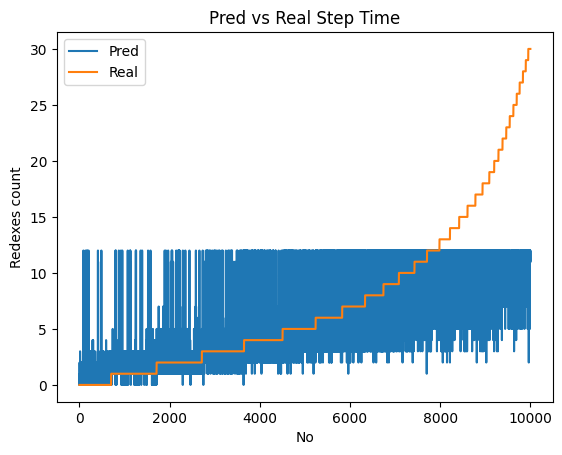

In [15]:
y_train_pred_nums = [np.argmax(y_) for y_ in y_train_pred]
y_train_nums = encoder.inverse_transform(y_train[:10_000])

draw_pred_lines(y_train_pred_nums, y_train_nums)

In [16]:
print("Train accuracy:", calculate_accuracy(y_train_nums, y_train_pred_nums))

Train accuracy: 0.2146


In [17]:
y_test_pred = []
y_test_pred_reg = []
for x_ in tqdm(x_test):
    prediction = model.predict(np.array([x_]), verbose=0)
    y_test_pred.append(prediction[0])
    y_test_pred_reg.append(prediction[1])

100%|██████████| 721/721 [00:50<00:00, 14.32it/s]


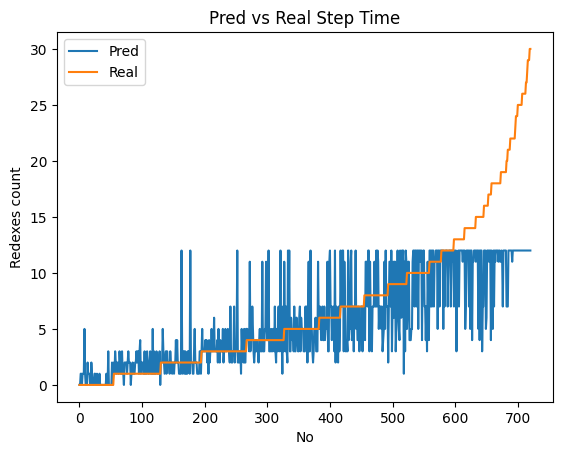

In [18]:
y_test_pred_nums = [np.argmax(y_) for y_ in y_test_pred]
y_test_nums = encoder.inverse_transform(y_test)

draw_pred_lines(y_test_pred_nums, y_test_nums)

In [19]:
print("Test accuracy:", calculate_accuracy(y_test_nums, y_test_pred_nums))

Test accuracy: 0.24410540915395285


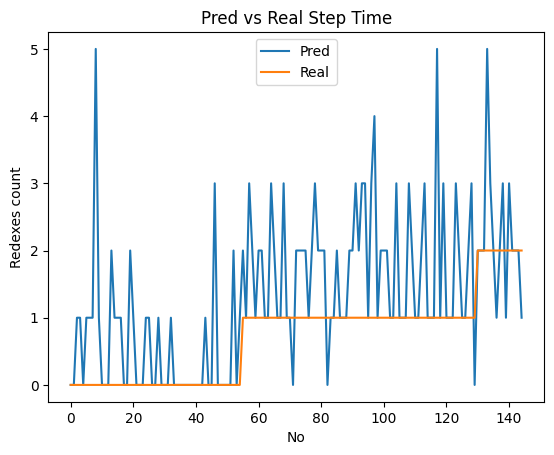

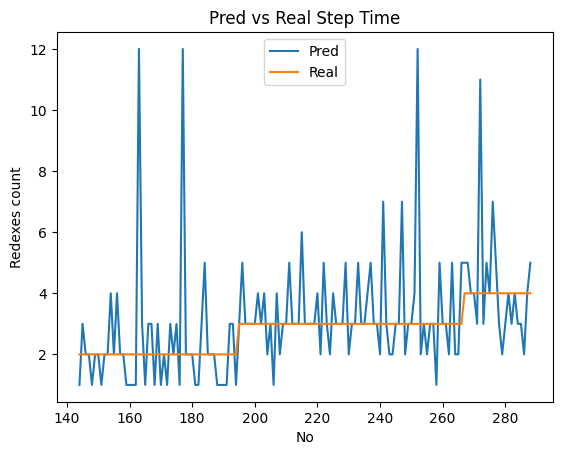

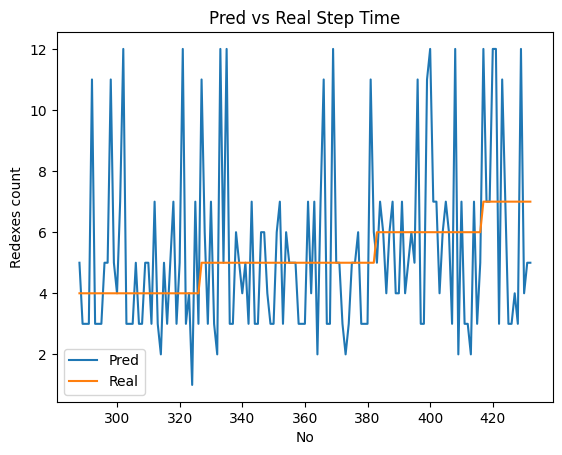

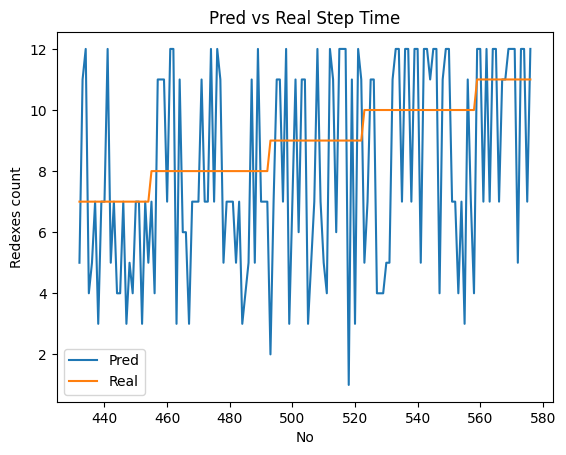

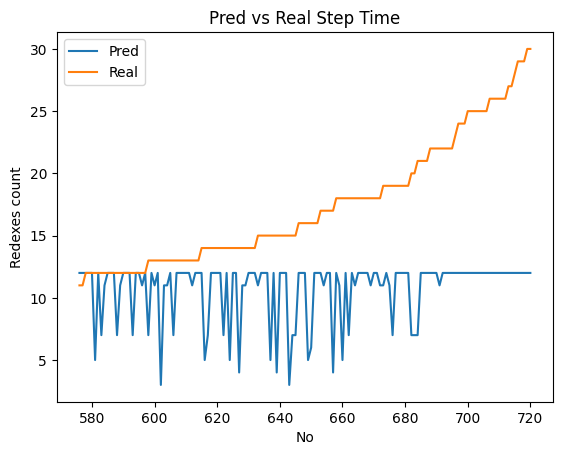

In [20]:
def draw_pred_lines_steps(y_pred, y_real, ranges):
    drawing_df = pd.DataFrame({"Pred": y_pred, "Real": y_real})
    drawing_df = drawing_df.sort_values("Real").reset_index(drop=True)

    range_step = int(len(y_pred) / ranges)
    for range_no in range(ranges):
        for key_, val_ in drawing_df.items():
            plt.plot(range(range_no * range_step, ((range_no + 1) * range_step) + 1),
                     val_[range_no * range_step: ((range_no + 1) * range_step) + 1], label=key_)

        plt.xlabel("No")
        plt.ylabel("Redexes count")
        plt.title("Pred vs Real Step Time")
        plt.legend()
        plt.show()


draw_pred_lines_steps(y_test_pred_nums, y_test_nums, 5)

# Do additional metrics testing

In [21]:
y_train_cl_pred_nums = [np.argmax(y_) for y_ in y_train_pred]
y_train_reg_pred_nums = np.array([y_[0][0] for y_ in y_train_pred_reg]) * 30.0

y_train_nums = encoder.inverse_transform(y_train)

In [22]:
y_test_cl_pred_nums = [np.argmax(y_) for y_ in y_test_pred]
y_test_reg_pred_nums = np.array([y_[0][0] for y_ in y_test_pred_reg]) * 30.0

y_test_nums = encoder.inverse_transform(y_test)

## Mean Squared Error

In [23]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import explained_variance_score

In [26]:
mse_train = mean_squared_error(y_train_nums[:10_000], y_train_cl_pred_nums[:10_000])
mse_train_reg = mean_squared_error(y_train_nums[:10_000], y_train_reg_pred_nums[:10_000])
print("Train {Mean Squared Error}:", mse_train)
print("Train reg {Mean Squared Error}:", mse_train_reg)

mse_test = mean_squared_error(y_test_nums, y_test_cl_pred_nums)
mse_test_reg = mean_squared_error(y_test_nums, y_test_reg_pred_nums)
print("Test {Mean Squared Error}:", mse_test)
print("Test reg {Mean Squared Error}:", mse_test_reg)

Train {Mean Squared Error}: 24.3874
Train reg {Mean Squared Error}: 25.137325978676238
Test {Mean Squared Error}: 18.482662968099863
Test reg {Mean Squared Error}: 20.93241769502467


## Mean Absolute Error

In [27]:
mae_train = mean_absolute_error(y_train_nums[:10_000], y_train_cl_pred_nums[:10_000])
mae_train_reg = mean_absolute_error(y_train_nums[:10_000], y_train_reg_pred_nums[:10_000])
print("Train {Mean Absolute Error}:", mae_train)
print("Train reg {Mean Absolute Error}:", mae_train_reg)

mae_test = mean_absolute_error(y_test_nums, y_test_cl_pred_nums)
mae_test_reg = mean_absolute_error(y_test_nums, y_test_reg_pred_nums)
print("Test {Mean Absolute Error}:", mae_test)
print("Test reg{Mean Absolute Error}:", mae_test_reg)

Train {Mean Absolute Error}: 3.0802
Train reg {Mean Absolute Error}: 3.829588739550114
Test {Mean Absolute Error}: 2.635228848821082
Test reg{Mean Absolute Error}: 3.5213359495968493


## Mean Absolute Percentage Error

In [28]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true_fix = np.array([y_ + 0.0001 for y_ in y_true])
    percentage_errors = np.abs((y_true - y_pred) / y_true_fix) * 100
    mape = np.mean(percentage_errors)
    return mape


mape_train = mean_absolute_percentage_error(y_train_nums[:10_000], y_train_cl_pred_nums[:10_000])
mape_train_reg = mean_absolute_percentage_error(y_train_nums[:10_000], y_train_reg_pred_nums[:10_000])
print("Train {Mean Absolute Percentage Error}:", mape_train)
print("Train reg {Mean Absolute Percentage Error}:", mape_train_reg)

mape_test = mean_absolute_percentage_error(y_test_nums, y_test_cl_pred_nums)
mape_test_reg = mean_absolute_percentage_error(y_test_nums, y_test_reg_pred_nums)
print("Test {Mean Absolute Percentage Error}:", mape_test)
print("Test reg {Mean Absolute Percentage Error}:", mape_test_reg)

Train {Mean Absolute Percentage Error}: 60842.697922713756
Train reg {Mean Absolute Percentage Error}: 168516.00681850134
Test {Mean Absolute Percentage Error}: 41646.92646345872
Test reg {Mean Absolute Percentage Error}: 172432.82141180412


## Percentage of Explained Variance (PEV)

In [29]:
# Calculate Variance of the target variable
variance_y_test = np.var(y_test_nums)
variance_y_train = np.var(y_train_nums[:10_000])

# Calculate Percentage of Explained Variance (PEV)
pev_test = (1 - mse_test / variance_y_test) * 100
pev_test_reg = (1 - mse_test_reg / variance_y_test) * 100
pev_train = (1 - mse_train / variance_y_train) * 100
pev_train_reg = (1 - mse_train_reg / variance_y_train) * 100

print("Train {Percentage of Explained Variance}:", pev_train)
print("Train reg {Percentage of Explained Variance}:", pev_train_reg)
print("Test {Percentage of Explained Variance}:", pev_test)
print("Test reg {Percentage of Explained Variance}:", pev_test_reg)

Train {Percentage of Explained Variance}: 49.3821998108536
Train reg {Percentage of Explained Variance}: 47.82567458285537
Test {Percentage of Explained Variance}: 54.03228422380047
Test reg {Percentage of Explained Variance}: 47.9395675409805


## Mean Bias Deviation

In [30]:
def mean_bias_deviation(y_true, y_pred):
    y_true_fix = np.array([y_ + 0.0001 for y_ in y_true])
    n = len(y_true)
    mbd = np.sum((y_pred - y_true) / y_true_fix) * 100 / n
    return mbd


mbd_train = mean_bias_deviation(y_train_nums[:10_000], y_train_cl_pred_nums[:10_000])
mbd_train_reg = mean_bias_deviation(y_train_nums[:10_000], y_train_reg_pred_nums[:10_000])
print("Train {Mean Bias Deviation}:", mbd_train)
print("Train reg {Mean Bias Deviation}:", mbd_train_reg)

mdb_test = mean_bias_deviation(y_test_nums, y_test_cl_pred_nums)
mdb_test_reg = mean_bias_deviation(y_test_nums, y_test_reg_pred_nums)
print("Test {Mean Bias Deviation}:", mdb_test)
print("Test reg {Mean Bias Deviation}:", mdb_test_reg)

Train {Mean Bias Deviation}: 60806.08826116921
Train reg {Mean Bias Deviation}: 158720.12803942393
Test {Mean Bias Deviation}: 41611.75513384141
Test reg {Mean Bias Deviation}: 105873.01460447065


## Coefficient of Correlation (Pearson's r)

In [32]:
coc_test = np.corrcoef(y_test_cl_pred_nums, y_test_nums)[0, 1]
coc_test_reg = np.corrcoef(y_test_reg_pred_nums, y_test_nums)[0, 1]
coc_train = np.corrcoef(y_train_cl_pred_nums[:10_000], y_train_nums[:10_000])[0, 1]
coc_train_reg = np.corrcoef(y_train_reg_pred_nums[:10_000], y_train_nums[:10_000])[0, 1]

print("Train {Mean Bias Deviation}:", coc_train)
print("Train reg {Mean Bias Deviation}:", coc_train_reg)
print("Test {Mean Bias Deviation}:", coc_test)
print("Test reg {Mean Bias Deviation}:", coc_test_reg)

Train {Mean Bias Deviation}: 0.7488563862126079
Train reg {Mean Bias Deviation}: 0.7076989349030195
Test {Mean Bias Deviation}: 0.7705633301312219
Test reg {Mean Bias Deviation}: 0.7125898990186998
